# <div div style="text-align:center">Tropical Cyclone impact data comparison between Wikimpacts1.0 and EM-DAT database </div>

<div div style="text-align:center">
PhiRu Environmental Engineering Members: </br>
Bernal, Chiara (r1083013) </br>
Caligdong, Ronan (r0966302) </br>
Espejo, Kristine Nadeen (r1017911) </br>
Haghebaert, Lukas (r0826858) </br>
</div>

### AI Acknowledgment
AI-assisted tools (Chat GPT & Gemini) were used as an aid. For example, creating docstrings and identifying the appropriate functions. <br>

### Instructions
1. Create an environment using the PhiRuProj.yml file in the "Environments" folder. The name of the environment should be called "PhiRuProject".<br>
2. Open spyder (or your prefered IDE) and under the folder "Python_scripts" launch the python file "WORKINGFILE_PhiRu_RUN.py". This will run the code and output the relevant graphs in the "Images" folder.
* BONUS: Open the file "GUI.py" and run it. This will open a GUI that you can use to analyse the data while using different year as a filter threshold. <br>

  Once you have created your environment you can try running the "RUN_ME.bat" file to launch the GUI directly. This will only work if anaconda3 is installed under your userprofile. 


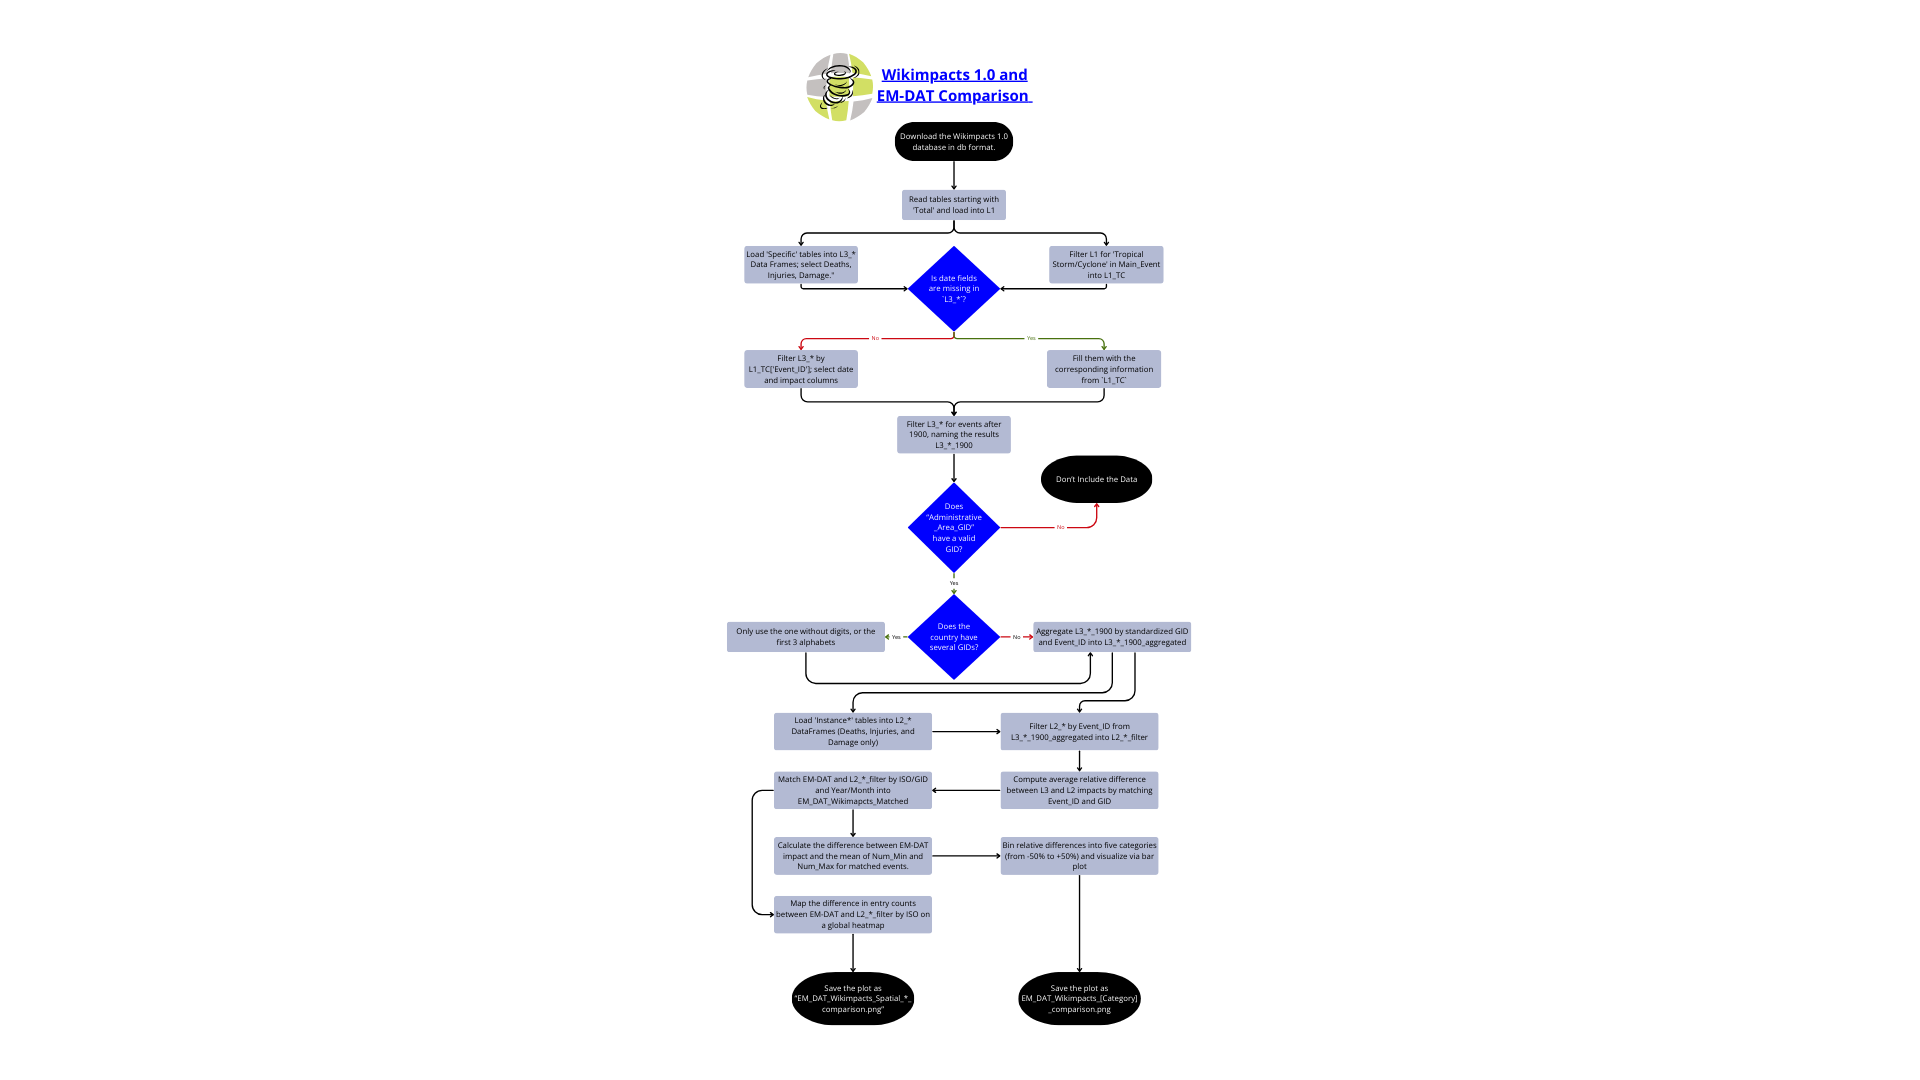

## Dataset
1. **Wikimpacts 1.0**：contains data on the occurrence and impacts of climate extremes in country and sub-national scales. The database is inferred from Wikipedia and uses generative AI. Download it from the following [link](https://github.com/VUB-HYDR/Wikimpacts/blob/main/releases/impactdb.v1.0.2.dg_filled.db) and place it in the "Data" folder.</br> 
2. **EM-DAT**, downloaded from Public EM-DAT platform, using only “tropical cyclone”. This data-set is already on the Git Hub folder "Data".

## Tasks


### 1. Download the Wikimpacts 1.0 database in db format. 



The data from the Wikimpacts should be downloaded from this [link](https://github.com/VUB-HYDR/Wikimpacts/blob/main/releases/impactdb.v1.0.2.dg_filled.db). <br>

The data then has been places under directory "Data". 
For exapmle 'D:\Leuven\GitHub\EnvironmentalProgrammingProject_PhiRu\Data'

### 2. Load Data
- Read the database file and load all tables that start with "Total" into a DataFrame named `L1`.
- Identify all tables that start with "Specific" and load them into separate DataFrames named `L3_*`, where `*` represents impact categories, only load Deaths, Injuries and Damage.

This code is for the extraction of data from the raw dataframes. It only extract necessary data and put them in another dataframes.

Importing necessary modules.

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import ast # This library turns string "[...]" into list [...]
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# The code bellow was adjusted to allow the jupyter notebook to run #
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
target_folder = os.path.join(project_root, 'Python_script')
sys.path.append(target_folder)
import data_processing_functions as dpf
# The rest of the code as the same as the orignial #



db_path = os.path.join(project_root, 'Data', 'impactdb.v1.0.2.dg_filled.db')  # <-- database
conn = sqlite3.connect(db_path)


This code is commanding the database to show the list of all existing data and filter the table that we are interested with.

In [7]:
# List all tables
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';", conn)

all_total_tables = tables[tables["name"].str.startswith("Total")]["name"]


This code is concatenating all the data from table with a 
'Total' name on it and creates a list (L1). 

In [8]:
# Concatenate to one big L1 dataframe
L1_list = []
for table_name in all_total_tables:
    df = pd.read_sql(f"SELECT * FROM {table_name};", conn)
    df["source_table"] = table_name
    L1_list.append(df)

L1 = pd.concat(L1_list, ignore_index=True)


This code is for the data to be categorized or sort them. 

In [9]:
spec_tables = tables[tables["name"].str.startswith("Specific")]["name"].tolist()

L3 = {}  # empty dictionary of category -> dataframe

for table_name in spec_tables: #for each table that starts with specific
    #classifyinging tables into three impacts deaths, injuries & damage
    if "Deaths" in table_name:
        category = "Deaths"
    elif "Injuries" in table_name:
        category = "Injuries"
    elif "Damage" in table_name:
        category = "Damage"
    else:
        continue

    df = pd.read_sql(f"SELECT * FROM {table_name};", conn)
    df["source_table"] = table_name
    L3.setdefault(category, []).append(df) # if the lsit is not in the dictionary, create an empty list and add this new dataframe to that list.


This code turns the one dataframe in to three different datafrmes with each for deaths, injuries and damages. 

In [10]:
# Get only Deaths, Injuries and Damage
for category in L3:
    L3[category] = pd.concat(L3[category], ignore_index=True)

L3_Deaths = L3.get("Deaths")
L3_Injuries = L3.get("Injuries")
L3_Damage = L3.get("Damage")

### 3. Filter by “Tropical Storm/Cyclone”
- Using the “Main_Event”, filter the Tropical Storm/Cyclone events from L1 into a new dataframe “L1_TC”
- Using “Event_ID” from “L1_TC”, filter the “L3_*” with only impact from Tropical Storm/Cyclone
- “Start/End_Date_Year,” “Start/End_Date_Month,” and “Start/End_Date_Day” col-umns. If these date fields are missing in `L3_*`, fill them with the corresponding infor-mation from `L1_TC`.

In [11]:
filter_criteria = L1["Main_Event"] == "Tropical Storm/Cyclone"
L1_TC = L1[filter_criteria].copy() #Copy is very imprtant to ensure original data isn't altered

tc_events = L1_TC["Event_ID"].unique()

This function is applied to deaths, injuries, and damage datasets to keep only tropical cyclone–related records.

In [12]:
def filter_L3_tc(df, tc_events):
    """
    Filter a DataFrame to include only level-3 tropical cyclone events.

    The function selects rows whose 'Event_ID' is present in the provided
    list of tropical cyclone event identifiers.

    Args:
        df (pandas.DataFrame): Input DataFrame containing an 'Event_ID' column.
        tc_events (list or set): Collection of Event_IDs corresponding to
            level-3 tropical cyclone events.

    Returns:
        pandas.DataFrame: Filtered DataFrame containing only rows associated
        with level-3 tropical cyclone events.

    Raises:
        KeyError: If the 'Event_ID' column is not present in the DataFrame.
    """
    return df[df["Event_ID"].isin(tc_events)].copy()

L3_Deaths_TC = filter_L3_tc(L3_Deaths, tc_events)
L3_Injuries_TC = filter_L3_tc(L3_Injuries, tc_events)
L3_Damage_TC  = filter_L3_tc(L3_Damage, tc_events)


This code extracts the start and end date information for tropical cyclone events from the level-1 dataset.

In [15]:
date_cols = [
    "Start_Date_Year", "Start_Date_Month", "Start_Date_Day",
    "End_Date_Year", "End_Date_Month", "End_Date_Day"
]

L1_TC_dates = L1_TC[["Event_ID"] + date_cols].drop_duplicates()

This function fills missing date values in level-3 data using the corresponding dates from level-1 events.

In [16]:
def fill_dates(L3_tc, L1_TC_dates, date_cols):
    """
    Fill missing date values in level-3 event data using level-1 reference dates.

    The function merges level-3 tropical cyclone data with level-1 reference
    dates on 'Event_ID'. For each specified date column, missing values in the
    level-3 data are filled using the corresponding level-1 values.

    Args:
        L3_tc (pandas.DataFrame): Level-3 event data containing date columns
            and an 'Event_ID' column.
        L1_TC_dates (pandas.DataFrame): Level-1 reference data providing
            fallback date values, keyed by 'Event_ID'.
        date_cols (list of str): List of date column names to be filled.

    Returns:
        pandas.DataFrame: DataFrame with missing level-3 date values filled
        using level-1 reference dates.

    Raises:
        KeyError: If required columns are missing from the input DataFrames.
    """
    merged = L3_tc.merge(L1_TC_dates, on="Event_ID", how="left", suffixes=("", "_L1"))
    for col in date_cols:
        merged[col] = merged[col].fillna(merged[f"{col}_L1"])
        merged.drop(columns=[f"{col}_L1"], inplace=True)
    return merged

The date-filling function is applied to all level-3 datasets to ensure consistent temporal information.

In [17]:
L3_Deaths_TC = fill_dates(L3_Deaths_TC, L1_TC_dates, date_cols)
L3_Injuries_TC = fill_dates(L3_Injuries_TC, L1_TC_dates, date_cols)
L3_Damage_TC = fill_dates(L3_Damage_TC, L1_TC_dates, date_cols)

### 4. Filter by Date
- In each ` L3_* ` DataFrame, filter the records to include only those events that occurred after the year 1900. Name these filtered DataFrames as `L3_*_1900`.

In [18]:
def filter_year(df, year):
    
    ''' Filters the data frame according to the year you input. 
    The filter keeps everything after the year specified 
    (e.g. x>1900) '''
    
    if type(year) == int:
        year_mask = df["Start_Date_Year"]>year
        return df[year_mask].copy()
    else:
        print ("Year must be an int data type")
        
year_to_filter = 1900
L3_Deaths_TC_1900 = filter_year(L3_Deaths_TC, year_to_filter)
L3_Injuries_TC_1900 = filter_year(L3_Injuries_TC, year_to_filter)
L3_Damage_TC_1900 = filter_year(L3_Damage_TC, year_to_filter)

We created a function that allows us to filter a data base by year. This only works for data bases that have a column with the title "Start_Date_Year". <br>
An explaination how how to function works was added in the comments and an if statement was added to help trouble shoot errors users may encounter.

### 5. Aggregate by Administrative Area
- Using the “Administrative_Area_GID” column in each ` L3_*_1900` DataFrame obtained from Step 3, for the same “Event_ID”, aggregate the impact from the same “Administrative_Area_GID”. <br>
- Only consider the rows with one valid GID (specific cases like one country involving several GIDs, only use the one without digits, or the first 3 alphabets), name the new dataframe to `L3_*_1900_aggregated`

In [2]:
def get_single_valid_gid(gid_entry):#Checks every single GID at a time
    """
    The function cleans, standardizes, and validates country identifiers.
    It handles strings, lists, nested lists, and missing values. Only rows
    with exactly one valid 3-letter code are returned; all others result in NaN.

    Args:
        gid_entry (str, list, or None): Raw administrative area identifier.
            Can be a string (e.g., "USA" or "['USA']"), a list (e.g., ['USA']),
            a nested list (e.g., [['USA']]), or None/missing.

    Returns:
        str or numpy.nan: A single cleaned 3-letter country code in uppercase
        (e.g., 'CHN') if valid, otherwise np.nan.

    Raises:
        ValueError: If the input cannot be converted to a list using ast.literal_eval.
    """
#Handle empty or missing cells -> return NaN
    if gid_entry is None or (isinstance(gid_entry, float) and np.isnan(gid_entry)):
        return np.nan 

    #Convert strings that LOOK like lists into real Python lists
        #Examples:
            #    "['USA']"      -> ['USA']
            #    "[['USA']]"    -> [['USA']]
            #    "USA"          -> stays as "USA"
    if isinstance(gid_entry, str):
        try: #used ast module, turns strings into lists
            check_stringorlist = ast.literal_eval(gid_entry)  #convert string to python object
            # if literal_eval returns a list, use it
            if isinstance(check_stringorlist, list):
                gid_entry = check_stringorlist
        except (ValueError, SyntaxError):
            # If literal_eval fails, treat the string as a single element
            gid_entry = [gid_entry]

    #Ensure the entry is ALWAYS treated as a list of strings
        #Cases handled:
    #    gid_entry = "USA"        -> ['USA']
    #    gid_entry = ['USA']      -> ['USA']
    #    gid_entry = [['USA']]    -> ['USA']
    
    if isinstance(gid_entry, str):
        elements = [gid_entry]  #wrap single string in a list
    else:
        #If it's a list, flatten and ensure all elements are strings
        #Example: [['USA']] -> ['USA']
        flat_list = []
        for e in gid_entry:
            if isinstance(e, list):
                flat_list.extend(e)  # Flatten nested lists
            else:
                flat_list.append(e)
        # Convert all elements to strings and remove NaNs
        elements = [str(e) for e in flat_list if pd.notna(e)]

    # 4. Extract valid 3-letter country codes
    valid_codes = []  # Start an empty list to store valid country codes
    
    for e in elements:  # Loop through every cleaned element
        # Clean formatting: remove whitespace, take first 3 chars, force UPPERCASE
        # Examples:
        #   'AUS.10' -> 'AUS'
        #   'chn'    -> 'CHN'
        code = e.strip()[:3].upper()

        # Validation rule:
        # Must be exactly 3 letters AND contain only letters
        if len(code) == 3 and code.isalpha():
            valid_codes.append(code)

    # 5. Enforce "Single Valid GID"
    #    Only accept rows with EXACTLY ONE valid country code
    if len(valid_codes) == 1:
        return valid_codes[0]  # Return the clean code (ex: 'CHN')
    else:
        return np.nan  # If zero or multiple codes found -> discard row

This code is our GID-cleaning function, we created a function that cleans each GID entry one at a time.<br>
We handled the cleaning in several steps:

- **First, we checked whether the cell was empty or missing.**<br>
    -> If it was, we simply returned `NaN` so we wouldn’t process invalid or unusable data.<br>
    -> This prevents errors and keeps the dataset clean from the start.

- **Next, we handled entries that were stored as text.**<br>
    -> Many GID values were saved as strings that *looked* like lists (for example: `"['USA']"` or `"[['USA']]"`).<br>
    -> To deal with this, we imported the `ast` library because it allows us to safely convert these string representations into actual Python list objects.

- **Then, we attempted to convert the text into real Python lists using `ast.literal_eval`.**<br>
    -> If the conversion worked and produced a list, we used that list as the cleaned version of the entry.<br>
    -> If the conversion failed (for example, if the value was just `"USA"`), we treated the value as a single‑item list like `['USA']` so that all entries follow the same structure.<br>
    -> By doing this, we standardized all GID formats into clean, consistent lists, making them much easier to filter, validate, and aggregate later in the process.


In the next part of the function, we made sure that every GID entry is treated as a clean list of strings and then extracted a single valid country code from it.<br>
We did this in several steps:

- **First, we ensured that the entry is always treated as a list.**<br>
    -> If `gid_entry` was just a single string like `"USA"`, we wrapped it into a list, becoming `['USA']`.<br>
    -> If `gid_entry` was already a list (for example `['USA']` or even `[['USA']]`), we processed it differently in the next step.<br>
    -> This step guarantees that, no matter the original format, we can handle all entries in a consistent way.

- **Next, we flattened list structures and cleaned the elements.**<br>
    -> If `gid_entry` was a list, we created an empty list called `flat_list` and went through each element `e`.<br>
    -> If an element `e` was itself a list (e.g., `['USA']` inside `[['USA']]`), we extended `flat_list` with its contents to remove nesting.<br>
    -> If `e` was not a list, we simply appended it to `flat_list`.<br>
    -> After flattening, we converted all elements to strings and removed any `NaN` values, storing the result in `elements`.<br>
    -> This step makes sure we end up with a simple, clean list of string values that we can safely process.

- **Then, we extracted valid 3-letter country codes from these cleaned elements.**<br>
    -> We created an empty list called `valid_codes` to store valid country codes.<br>
    -> For each element `e` in `elements`, we removed extra spaces, took only the first three characters, and converted them to uppercase.<br>
    -> For example: `'AUS.10'` becomes `'AUS'`, and `'chn'` becomes `'CHN'`.<br>
    -> We then checked if this code was exactly 3 characters long and contained only letters. If so, we added it to `valid_codes`.<br>
    -> This step ensures that we only keep properly formatted 3-letter country codes.

- **Finally, we enforced the “single valid GID” rule.**<br>
    -> If `valid_codes` contained exactly one valid country code, we returned that code (for example, `'CHN'`).<br>
    -> If there were no valid codes or more than one, we returned `NaN` and discarded that row.<br>
    -> This rule guarantees that only rows with one clear, unambiguous GID are kept for later analysis and aggregation.

In [19]:
def clean_dataframe(df):
    
    """
    Clean and standardize the administrative area GID column in a DataFrame.

    The function detects whether the DataFrame contains either
    'Administrative_Area_GID' or 'Administrative_Areas_GID', normalizes the
    column format if necessary, applies a validation and extraction routine
    to obtain a single valid GID per row, and removes rows with invalid or
    missing GID values.

    Args:
        df (pandas.DataFrame): Input DataFrame containing administrative area
            identifier columns and event-level data.

    Returns:
        pandas.DataFrame: Cleaned DataFrame with a standardized administrative
        area GID column and invalid rows removed.

    Raises:
        KeyError: If neither 'Administrative_Area_GID' nor
        'Administrative_Areas_GID' is present in the DataFrame.
    """
    
    df_clean = df.copy()

    # 1. IDENTIFY THE COLUMN
    if 'Administrative_Area_GID' in df_clean.columns:
        target_col = 'Administrative_Area_GID'

        print("TARGET COLUMN:", target_col)
        print("FIRST VALUES:\n", df_clean[target_col].head())
        print("COLUMN DTYPE:", df_clean[target_col].dtype)
        print("PYTHON TYPE OF VALUE:", type(df_clean[target_col].iloc[2]))

    elif 'Administrative_Areas_GID' in df_clean.columns:
        target_col = 'Administrative_Areas_GID'

        #Step 1: Convert string "[['USA']]" -> [['USA']]
        df_clean[target_col] = df_clean[target_col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

        #Step 2: Flatten [['USA']] -> ['USA']
        df_clean[target_col] = df_clean[target_col].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
        )

        #Step 3: Convert ['USA'] -> "['USA']" (string)
        df_clean[target_col] = df_clean[target_col].apply(
            lambda x: str([x]) if isinstance(x, str) else x
        )

        print("TARGET COLUMN:", target_col)
        print("FIRST VALUES:\n", df_clean[target_col].head())
        print("COLUMN DTYPE:", df_clean[target_col].dtype)
        print("PYTHON TYPE OF VALUE:", type(df_clean[target_col].iloc[2]))

    else:
        print("Error: Neither GID column found.")
        return df_clean

    #return df_clean
    
    # Debug: Confirm which column is being used
    print(f"Detected column: {target_col}")
    
    # Debug: Print before cleaning to see what we are dealing with
    print(f"Rows before cleaning: {len(df_clean)}")
    
    # A. Clean the GID column
    # Apply the complex cleaning function to every row in the 'Administrative_Area_GID' column
    df_clean[target_col] = df_clean[target_col].apply(get_single_valid_gid) 
    
    # B. Filter out the NaNs
    # Remove any row where the GID cleaning process returned NaN (discarding bad/multiple GID rows)
    df_clean = df_clean.dropna(subset=[target_col]) 
    
    # Debug: Print after cleaning
    print(f"Rows after cleaning: {len(df_clean)}")
    return df_clean

In this part of the code, we created a main function that processes an entire dataframe and cleans its GID column step by step.<br>
The goal of this function is to detect the correct GID column, standardize its format, apply our GID‑cleaning function, and remove invalid rows.<br>
We handled this in several stages:

**1. We identified which GID column exists in the dataframe.**  
Different datasets use different column names, so we checked both possibilities.

- **If the dataframe contains `Administrative_Area_GID`:**<br>
    -> We set this as our target column.<br>
    -> We printed sample values and data types to understand the format before cleaning.

- **If the dataframe contains `Administrative_Areas_GID`:**<br>
    -> We set this as the target column and performed three preprocessing steps:<br>
    -> Step 1: Convert strings like `"[['USA']]"` into actual Python lists using `ast.literal_eval`.<br>
    -> Step 2: Flatten nested lists such as `[['USA']]` into `['USA']`.<br>
    -> Step 3: Convert the list back into a string format like `"['USA']"` so it matches the expected input format of our cleaning function.<br>
    -> We printed sample values again to confirm the transformation.

- **If neither column exists:**<br>
    -> We printed an error message and returned the dataframe unchanged.

**2. We printed debug information before cleaning.**  
These debug prints help us understand what the dataframe looks like before applying the cleaning function.<br>
-> We printed which column was detected.<br>
-> We printed how many rows the dataframe had before cleaning.

**3. We applied the GID‑cleaning function to every row.**  
-> We used `.apply(get_single_valid_gid)` to clean each GID entry one at a time.<br>
-> This step standardizes messy formats and extracts a single valid 3‑letter country code.

**4. We removed rows with invalid or ambiguous GIDs.**  
-> If the cleaning function returned `NaN` (meaning zero or multiple valid codes), we dropped those rows using `dropna`.<br>
-> This ensures that only rows with one clear, valid GID remain.

**5. We printed debug information after cleaning.**  
-> We printed how many rows remained after filtering out invalid entries.<br>
-> This helps us verify how much data was cleaned or discarded.

**6. Finally, we returned the cleaned dataframe.**  
-> At this point, the dataframe contains only rows with a single valid GID.<br>
-> This cleaned version is ready for aggregation and further analysis.

In [21]:
def aggregate_by_eventID(df_clean):
    
    """
    Aggregate event-level data while preventing unintended summation of date fields.

    The function groups the input DataFrame by event ID and administrative area,
    applying column-specific aggregation rules. Numerical impact columns are summed,
    while all other columns retain their first observed value to avoid invalid
    aggregations (e.g., adding years).

    Args:
        df_clean (pandas.DataFrame): Cleaned DataFrame containing event-level data
            with numerical impact columns and metadata.

    Returns:
        pandas.DataFrame: Aggregated DataFrame with one row per event ID and
        administrative area, using fixed aggregation rules.

    """
    
    # 1. Define the columns we are grouping by
    group_cols = ['Event_ID', 'Administrative_Area_GID'] # The keys that must be identical to form a group
    
    # 2. Create the "Rule Book" for aggregation
    agg_rules = {} # This dictionary tells Pandas what math to do for each column
    
    # Loop through every column to decide what to do with it
    for col in df_clean.columns:
        if col in group_cols:
            continue # Skip the grouping keys—they are handled automatically by groupby
            
        # If it is a Numerical Impact column -> SUM it
        if col in ['Num_Min', 'Num_Max', 'Num_Approx']:
            agg_rules[col] = 'sum' # Add the numbers together
            
        # For Dates and everything else -> KEEP FIRST value
        # (This prevents adding 1992 + 1992)
        else:
            agg_rules[col] = 'first' # Just take the first value found in the group

    # 3. Apply the rules
    # Groups the rows, applies the specific SUM/FIRST rules, and flattens the result
    df_agg = df_clean.groupby(group_cols).agg(agg_rules).reset_index()
    
    return df_agg

In this part of the code, we created a function that aggregates the cleaned dataframe by combining rows that belong to the same Event_ID and the same Administrative_Area_GID.<br>
The goal is to sum numerical impact values while keeping non‑numerical information consistent and avoiding incorrect operations like adding years together.<br>
We handled this in several steps:

**1. We defined the columns used for grouping.**  
Different datasets use different column names, so we checked both possibilities.

- **Grouping columns:**<br>
    -> `Event_ID`<br>
    -> `Administrative_Area_GID`<br>
    -> Rows with the same values in these two columns will be merged into one.

**2. We created a “rule book” for how each column should be aggregated.**  
We built a dictionary called `agg_rules` that tells Pandas what operation to apply to each column.

- **For each column in the dataframe:**<br>
    -> If the column is one of the grouping keys, we skip it because `groupby` handles those automatically.<br>
    -> If the column is a numerical impact column (`Num_Min`, `Num_Max`, `Num_Approx`), we sum the values.<br>
    -> For all other columns (like dates, names, descriptions), we keep only the first value found in the group.<br>
    -> This prevents incorrect operations such as adding years (e.g., `1992 + 1992`).

**3. We applied the aggregation rules to the dataframe.**  
-> We used `groupby(group_cols).agg(agg_rules)` to combine rows that belong to the same event and administrative area.<br>
-> The `.reset_index()` step flattens the grouped result back into a normal dataframe.<br>
-> The final output contains one row per unique combination of Event_ID and Administrative_Area_GID.

**4. We returned the aggregated dataframe.**  
-> At this point, all numerical impacts are properly summed.<br>
-> All non‑numerical fields are kept consistent by taking the first value.<br>
-> The dataframe is now ready for analysis or merging with other datasets.

In [22]:
#Aggregate by Administrative Area

# Execute the process on each of our filtered dataframes:
L3_Deaths_TC_1900_aggregated = dpf.aggregate_by_eventID(dpf.clean_dataframe(L3_Deaths_TC_1900))
L3_Damage_TC_1900_aggregated = dpf.aggregate_by_eventID(dpf.clean_dataframe(L3_Damage_TC_1900))
L3_Injuries_Damage_TC_1900_aggregated = dpf.aggregate_by_eventID(dpf.clean_dataframe(L3_Injuries_TC_1900))

TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0                         ['MEX']
1                         ['PHL']
2                         ['TWN']
3    ['Z03', 'CHN', 'Z08', 'Z02']
4                         ['JPN']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Administrative_Area_GID
Rows before cleaning: 4170
Rows after cleaning: 4005
TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0    ['CUB']
1    ['PHL']
2    ['PHL']
3    ['PHL']
4    ['SLB']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Administrative_Area_GID
Rows before cleaning: 6581
Rows after cleaning: 6324
TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0        ['MEX']
1        ['USA']
2        ['USA']
3        ['TWN']
4    ['CHN.HKG']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Adminis

In this final part of the code, we executed the entire cleaning and aggregation pipeline on each of our filtered dataframes.<br>
The goal here was to apply the same standardized process to all datasets so that they become consistent and ready for analysis.<br>
We handled this in a straightforward sequence:

**1. We applied the cleaning function to each dataframe.**  
-> We used `clean_dataframe(...)` to detect the correct GID column, standardize its format, clean each GID entry, and remove invalid rows.<br>
-> This ensures that every dataset has only one valid GID per row before aggregation.

**2. We applied the aggregation function to the cleaned data.**  
-> We used `aggregate_by_eventID(...)` to group rows by `Event_ID` and `Administrative_Area_GID`.<br>
-> Numerical impact values were summed, while non‑numerical fields kept their first valid entry.<br>
-> This step produces one clean, aggregated row per event per administrative area.

**3. We stored the final aggregated outputs.**  
-> `L3_Deaths_TC_1900_aggregated` contains the cleaned and aggregated deaths data.<br>
-> `L3_Damage_TC_1900_aggregated` contains the cleaned and aggregated damage data.<br>
-> `L3_Injuries_Damage_TC_1900_aggregated` contains the cleaned and aggregated injuries data.<br>
-> All three outputs now follow the same structure and can be compared or merged easily.

This completes the full cleaning and aggregation workflow for all filtered datasets.

### 6. Comparison with L2 tables
- Read all tables that start with "Instance" and load them into separate DataFrames named `L2_*`, where `*` represents impact categories, only load Deaths, Injuries and Damage.
- Using the same Event_ID from ‘L3_*_1900_aggregated’, filter the events from ’ L2_*`, name as ‘L2_*_filter`
- For the same Event_ID events, using the “Administrative_Area_GID” from ‘L3_*_1900_aggregated’ and the “Administrative_Areas_GID” from ‘L2_*_filter`, map the same GID, compute the impact data difference between ‘L3_*_1900_aggregated’ and ‘L2_*_filter`, for each impact category, get the average relative difference score. (‘L3_*_1900_aggregated’/ ‘L2_*_filter`)/ ‘L2_*_filter`.

**1. Read all tables with Instance & load Deaths, Injuries and Damage** <br>

We approached this in the same way we approached the reading of the specific table.

In [23]:
instance_tables = tables[tables["name"].str.startswith("Instance")]["name"].tolist()

L2 = {}  # dictionary of category -> dataframe

for table_name in instance_tables: #for each table that starts with instance
    #classifyinging tables into three impacts deaths, injuries & damage
    if "Deaths" in table_name:
        category = "Deaths"
    elif "Injuries" in table_name:
        category = "Injuries"
    elif "Damage" in table_name:
        category = "Damage"
    else:
        continue

    df = pd.read_sql(f"SELECT * FROM {table_name};", conn)
    
    # Keep track of source table with the table name
    df["source_table"] = table_name                       
    L2.setdefault(category, []).append(df)

# Combining the databases under the dictionary's category into a single database
# Important since there are multiple tables with instance_damage
for category in L2:                        
    L2[category] = pd.concat(L2[category], ignore_index=True)

**2. Clean the dataframe & filter by matching with events from L3\*1900_aggregated** <br>


In [24]:
# Cleaning data using the same function defined in Task 5
L2_Deaths = dpf.clean_dataframe(L2.get("Deaths"))
L2_Injuries = dpf.clean_dataframe(L2.get("Injuries"))
L2_Damage = dpf.clean_dataframe(L2.get("Damage"))

#---- Using  Event_ID from ‘L3_*_1900_aggregated’ filter the events from ’ L2_*`, name as ‘L2_*_filter`
#Extract Event ID from L3*1900_aggregated
L3_deaths_ids = L3_Deaths_TC_1900_aggregated["Event_ID"].unique()
L3_injuries_ids = L3_Injuries_Damage_TC_1900_aggregated["Event_ID"].unique()
L3_damage_ids = L3_Damage_TC_1900_aggregated["Event_ID"].unique()

#Filter L2 using these Event_ID's from L3
L2_Deaths_filter = L2_Deaths[L2_Deaths["Event_ID"].isin(L3_deaths_ids)].copy()
L2_Injuries_filter = L2_Injuries[L2_Injuries["Event_ID"].isin(L3_injuries_ids)].copy()
L2_Damage_filter = L2_Damage[L2_Damage["Event_ID"].isin(L3_damage_ids)].copy()

TARGET COLUMN: Administrative_Areas_GID
FIRST VALUES:
 0    [USA.4_1]
1        [USA]
2        [USA]
3        [USA]
4        [CAN]
Name: Administrative_Areas_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'list'>
Detected column: Administrative_Areas_GID
Rows before cleaning: 4225
Rows after cleaning: 4054
TARGET COLUMN: Administrative_Areas_GID
FIRST VALUES:
 0    [USA]
1    [USA]
2    [JPN]
3    [USA]
4    [USA]
Name: Administrative_Areas_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'list'>
Detected column: Administrative_Areas_GID
Rows before cleaning: 1782
Rows after cleaning: 1720
TARGET COLUMN: Administrative_Areas_GID
FIRST VALUES:
 0    [PHL]
1    [CAN]
2    [CAN]
3    [JPN]
4    [USA]
Name: Administrative_Areas_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'list'>
Detected column: Administrative_Areas_GID
Rows before cleaning: 5496
Rows after cleaning: 5232


**3. Standardize and merge data from L3 & L2 for the relative difference**

In [25]:
# Standardizing the country codes
L2_Deaths_filter = L2_Deaths_filter.rename(columns={"Administrative_Areas_GID": "Administrative_Area_GID"})
L2_Injuries_filter = L2_Injuries_filter.rename(columns={"Administrative_Areas_GID": "Administrative_Area_GID"})
L2_Damage_filter = L2_Damage_filter.rename(columns={"Administrative_Areas_GID": "Administrative_Area_GID"})

# Merging L3 and L2
merged_deaths = L3_Deaths_TC_1900_aggregated.merge(
    L2_Deaths_filter,
    on=["Event_ID", "Administrative_Area_GID"],
    suffixes=("_L3", "_L2")
)

merged_injuries = L3_Injuries_Damage_TC_1900_aggregated.merge(
    L2_Injuries_filter,
    on=["Event_ID", "Administrative_Area_GID"],
    suffixes=("_L3", "_L2")
)

merged_damage = L3_Damage_TC_1900_aggregated.merge(
    L2_Damage_filter,
    on=["Event_ID", "Administrative_Area_GID"],
    suffixes=("_L3", "_L2")
)

# Keeping only the required columns
cols_to_keep = [
    "Event_ID",
    "Administrative_Area_GID",
    "Num_Min_L3", "Num_Max_L3", "Num_Approx_L3",
    "Num_Min_L2", "Num_Max_L2", "Num_Approx_L2"
]

merged_deaths = merged_deaths[cols_to_keep].copy()
merged_injuries = merged_injuries[cols_to_keep].copy()
merged_damage = merged_damage[cols_to_keep].copy()

**4. Function definition & computing the relative differences**

In [26]:
def rel_diff_between_data_levels(df, col):
    '''
    Compute the relative difference between level 3 and level 2 data.
    
    The relative difference is defined as (L3 − L2) / L2, subject to a set of
    predefined rules handling zero and missing values. The input DataFrame
    must already contain merged level-2 and level-3 data with suffixes
    `_L2` and `_L3`.
    
    Args:
        df (pandas.DataFrame): DataFrame containing merged level-2 and level-3
            data, aggregated by country and event ID.
        col (str): Base column name to compute the relative difference for.

    Returns:
        numpy.ndarray: Array containing the relative difference values computed
        according to the specified rules.
    
    '''
    L3 = df[f"{col}_L3"]
    L2 = df[f"{col}_L2"]

    # Condition 1: If either is NaN -> 0
    cond_nan = L3.isna() | L2.isna()

    # Condition 2: If both zero -> 0
    cond_both_zero = (L3 == 0) & (L2 == 0)

    # Condition 3: If L3 > 0 and L2 = 0 -> 1
    cond_L3_pos_L2_zero = (L3 > 0) & (L2 == 0)

    # Condition 4: Normal case -> (L3 - L2) / L2
    normal_case = (L3 - L2) / L2

    # Build final vector using np.select
    return np.select(
        [cond_nan, cond_both_zero, cond_L3_pos_L2_zero],
        [0,        0,             1],
        default=normal_case)


In [27]:
# Computing relative differences
impact_columns = ["Num_Min", "Num_Max", "Num_Approx"]

# Computing relative difference per category, per impact column using defined function
for col in impact_columns:
    merged_deaths[f"{col}_rel_diff"] = dpf.rel_diff_between_data_levels(merged_deaths, col)
    merged_injuries[f"{col}_rel_diff"] = dpf.rel_diff_between_data_levels(merged_injuries, col)
    merged_damage[f"{col}_rel_diff"] = dpf.rel_diff_between_data_levels(merged_damage, col)

# Computing average relative difference per category for insight
# We use list comprehension below to find the relevent columns.
avg_rel_diff_deaths = merged_deaths[[c for c in merged_deaths.columns if "rel_diff" in c]].mean()
avg_rel_diff_injuries = merged_injuries[[c for c in merged_injuries.columns if "rel_diff" in c]].mean()
avg_rel_diff_damage = merged_damage[[c for c in merged_damage.columns if "rel_diff" in c]].mean()

List comprehension is similar to a compact loop except it uses temporary variables and creates a list (and hence can be performed quickly). <br>

The line `mearged_deaths[[c for c in merged_deaths.columns if "rel_diff" in c]].mean()` can be read as: <br>
"For a column in the data frame merged_deaths, if the column name contains rel_diff return the mean of the entire column

### 7. Identify and Analyze same tropical cyclone (TC) Events
- Using the ISO from EM-DAT, and Administrative_Areas_GID (only consider the row-with one GID) in ` L2_*_filter`, and “Start/End_Date_Year,” “Start/End_Date_Month,”, to identify the same TC events, and save a new dataframe as “EM_DAT_Wikimapcts_Matched”.
- Calculate the impact (e.g., Deaths, mean of Num_Min and Num_Max) difference of these matched events. Using the relative difference, and category the difference to 5 categories, -50% less, -30% less, Perfect Match, +30% more, +50% more, and visualize the difference in a bar plot. (relative difference: (Wikimpacts-EM_DAT)/EM_DAT)
- Save the plot as “EM_DAT_Wikimpacts_*_comparison.png”.


The fisrt code is for data loading and copying the data.  

In [29]:
# Load EM-DAT Excel file
emdat = pd.read_excel(os.path.join(project_root, 'Data', 'EMDAT.xlsx'),sheet_name="EM-DAT Data")

emdat = emdat[[
    "ISO",
    "Start Year", "Start Month",
    "End Year", "End Month", 'Total Deaths', 'No. Injured', "Total Damage ('000 US$)", "Total Damage, Adjusted ('000 US$)"
]].copy()

In this code the columns that were the necessary data to be extracted from was defined. The goal is to extract data from three different data frames. 

In [30]:
cols_for_matching = [
    "Event_ID",
    "Administrative_Area_GID",
    "Start_Date_Year", "Start_Date_Month",
    "End_Date_Year", "End_Date_Month",
    "Num_Min", "Num_Max", "Num_Approx"
]

L2_Deaths_match = L2_Deaths_filter[cols_for_matching].copy()
L2_Injuries_match = L2_Injuries_filter[cols_for_matching].copy()
L2_Damage_match = L2_Damage_filter[cols_for_matching].copy()


This code is to combine the two dataframes. The two data from EM-DAT and Wikimpacts1.0 are matched. To match this, we use .merge() to combine the data from two data frames.  left_on and right_on commands are just the names of the columns in the two dataframe that to be matched. how="inner" command is to keeps rows where a match is found in both datasets. 

In [31]:
match_deaths = L2_Deaths_match.merge(
    emdat,
    left_on=["Administrative_Area_GID", "Start_Date_Year", "Start_Date_Month", "End_Date_Year", "End_Date_Month"],
    right_on=["ISO", "Start Year", "Start Month", "End Year", "End Month"],
    how="inner"
)

match_injuries = L2_Injuries_match.merge(
    emdat,
    left_on=["Administrative_Area_GID", "Start_Date_Year", "Start_Date_Month", "End_Date_Year", "End_Date_Month"],
    right_on=["ISO", "Start Year", "Start Month", "End Year", "End Month"],
    how="inner"
)

match_damage = L2_Damage_match.merge(
    emdat,
    left_on=["Administrative_Area_GID", "Start_Date_Year", "Start_Date_Month", "End_Date_Year", "End_Date_Month"],
    right_on=["ISO", "Start Year", "Start Month", "End Year", "End Month"],
    how="inner"
)


In this code we are merging the three dataframes (death, injuries and damages) into one dataframe(EM_DAT_Wikimapcts_Matched). 

In [32]:
cols_final = [
    "Event_ID",
    "ISO",
    "Administrative_Area_GID",
    "Start_Date_Year", "Start_Date_Month",
    "End_Date_Year", "End_Date_Month",
    "Start Year", "Start Month", "End Year", "End Month",
    "Num_Min", "Num_Max", "Num_Approx",
    "Total Deaths",
    "No. Injured",
    "Total Damage ('000 US$)",
    "Total Damage, Adjusted ('000 US$)"
] #all three matched dataframes have the same columns as mentioned above.

match_deaths = match_deaths[cols_final].copy()
match_injuries = match_injuries[cols_final].copy()
match_damage = match_damage[cols_final].copy()

EM_DAT_Wikimapcts_Matched = pd.concat(
    [match_deaths, match_injuries, match_damage],
    ignore_index=True
    )


This code is to categegorize the level of match in the two dataframes (Wikimpacts-EM_DAT).The relative difference, and category the difference to 5 categories, -50% less, -30% less, Perfect Match, +30% more, +50% more. After this the result was shown in bar graphs. 

In [54]:
def process_and_plot_impacts(df, category_name, emdat_col):
    """
    Calculate Wikimpacts mean, compare against EM-DAT, categorize differences, and plot results.

    The function performs the following steps:
        1. Computes the row-wise mean of 'Num_Min' and 'Num_Max' as 'Wikimpact_Mean'.
        2. Calculates the relative difference between Wikimpacts and EM-DAT values.
        3. Categorizes the differences into bins representing over- or under-estimation.
        4. Plots a bar chart of the counts per category and saves the figure.

    Args:
        df (pandas.DataFrame): Input DataFrame containing 'Num_Min', 'Num_Max', and EM-DAT columns.
        category_name (str): Name of the category for labeling the plot and file.
        emdat_col (str): Name of the column in df containing EM-DAT values for comparison.

    Returns:
        pandas.DataFrame: DataFrame with added columns 'Wikimpact_Mean', 'Relative_Diff',
        and 'Impact_Category' reflecting the comparison results.

    Raises:
        KeyError: If required columns ('Num_Min', 'Num_Max', or emdat_col) are missing from df.
        ValueError: If EM-DAT values contain zeros leading to invalid relative difference calculations.
    """
    df = df.copy()
    
    # 1. Calculate Wikimpacts Mean (Row-wise mean of Min, Max, Approx)
    # We use mean(axis=1) which ignores NaNs automatically. 
    df['Wikimpact_Mean'] = df[['Num_Min', 'Num_Max']].mean(axis=1)
    
    # 2. Calculate Relative Difference: (Wikimpacts - EM_DAT) / EM_DAT
    # We must handle cases where EM_DAT is 0 or NaN to avoid infinite errors.
    
    # Extract series for easier handling
    wiki_val = df['Wikimpact_Mean']
    emdat_val = df[emdat_col]
    
    # Define logic for division
    # Case A: Both are 0 -> 0 diff (Perfect Match)
    # Case B: EM_DAT is 0 but Wiki > 0 -> Treat as High Positive (set to 1.0 for binning)
    # Case C: Standard Formula
    
    conditions = [
        (emdat_val == 0) & (wiki_val == 0), # Both zero
        (emdat_val == 0) & (wiki_val > 0),  # EM_DAT zero, Wiki positive
        (emdat_val.isna()) | (wiki_val.isna()) # Missing data
    ]
    
    choices = [
        0.0,  # Perfect match
        1.0,  # Arbitrary high number to push it into +50% bin
        0.0
    ]
    
    # Calculate standard formula
    standard_calc = (wiki_val - emdat_val) / emdat_val
    
    # Apply logic
    df['Relative_Diff'] = np.select(conditions, choices, default=standard_calc)
    
    # Drop rows where we couldn't calculate a difference (NaNs)
    df = df.dropna(subset=['Relative_Diff'])

    # 3. Sort into 5 categories
    # Bins: 
    #   < -0.5       -> -50% less
    #   -0.5 to -0.3 -> -30% less
    #   -0.3 to 0.3  -> Perfect Match
    #   0.3 to 0.5   -> +30% more
    #   > 0.5        -> +50% more
    
    bins = [-np.inf, -0.5, -0.3, 0.3, 0.5, np.inf]
    labels = ['-50% less', '-30% less', '"Perfect" Match', '+30% more', '+50% more']
    
    df['Impact_Category'] = pd.cut(df['Relative_Diff'], bins=bins, labels=labels)

    # 4. Visualization
    plt.figure(figsize=(10, 6))
    
    # Count the values for the plot
    ax = sns.countplot(x='Impact_Category', data=df, hue='Impact_Category', legend=False, palette='viridis', order=labels, dodge=False)
    
    # Formatting
    plt.title(f'Comparison of {category_name}: EM-DAT vs Wikimpacts', fontsize=15)
    plt.xlabel('Impact Difference Category', fontsize=12)
    plt.ylabel('Count of Events', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

    # Save the plot
    
    current_dir = os.path.dirname(os.path.abspath(__file__))
    project_root = os.path.dirname(current_dir)
    filename = f"EM_DAT_Wikimpacts_{category_name}_comparison.png"
    image_path = os.path.join(project_root, 'Images', filename)

    plt.savefig(image_path, dpi=300)
    print(f"Plot saved: {filename}")
    #plt.show() # Optional: Show plot in IDE

### 8. Analyze the spatial differences between two databases
- Using the ISO from EM-DAT, and Administrative_Areas_GID (only consider the row with one GID) in ` L2_*_filter`, compute the number of impact data entries difference between two databases, and visualize the difference in a world map.
- Save the plot as “EM_DAT_Wikimpacts_Spatial_*_comparison.png”.

In [34]:
import geopandas as gpd

**1. Aggregate EM-DAT impacts by country (ISO)**

In [35]:
emdat_country_counts = (
    emdat
    .groupby("ISO")
    .size()
    .reset_index(name="emdat_count")
)

**2. Aggregate Wikimpacts impacts by country (ISO)**

Using L2_*_filter (one row per GID as required)

In [36]:
wikimpacts_country_counts = pd.concat(
    [
        L2_Deaths_filter[["Administrative_Area_GID"]],
        L2_Injuries_filter[["Administrative_Area_GID"]],
        L2_Damage_filter[["Administrative_Area_GID"]]
    ],
    ignore_index=True
)

wikimpacts_country_counts = (
    wikimpacts_country_counts
    .groupby("Administrative_Area_GID")
    .size()
    .reset_index(name="wikimpacts_count")
    .rename(columns={"Administrative_Area_GID": "ISO"})
)

**3. Merge EM-DAT and Wikimpacts country-level counts**

In [37]:
spatial_comparison = emdat_country_counts.merge(
    wikimpacts_country_counts,
    on="ISO",
    how="outer"
).fillna(0)

**4. Compute spatial difference**

Positive values indicate more impacts in Wikimpacts and negative values indicate more impacts in EM-DAT

In [38]:
spatial_comparison["difference"] = (
    spatial_comparison["wikimpacts_count"] -
    spatial_comparison["emdat_count"]
)

**5. Load world geometry (Natural Earth dataset)**

The world shapefile is loaded from an external source to obtain standardized country geometries and ISO codes, ensuring consistency across datasets.

In [39]:
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)

**6. Merge spatial comparison with world map**

In [44]:
world_map = world.merge(
    spatial_comparison,
    left_on="ISO_A3",
    right_on="ISO",
    how="left"
)

**7. Plot spatial differences**

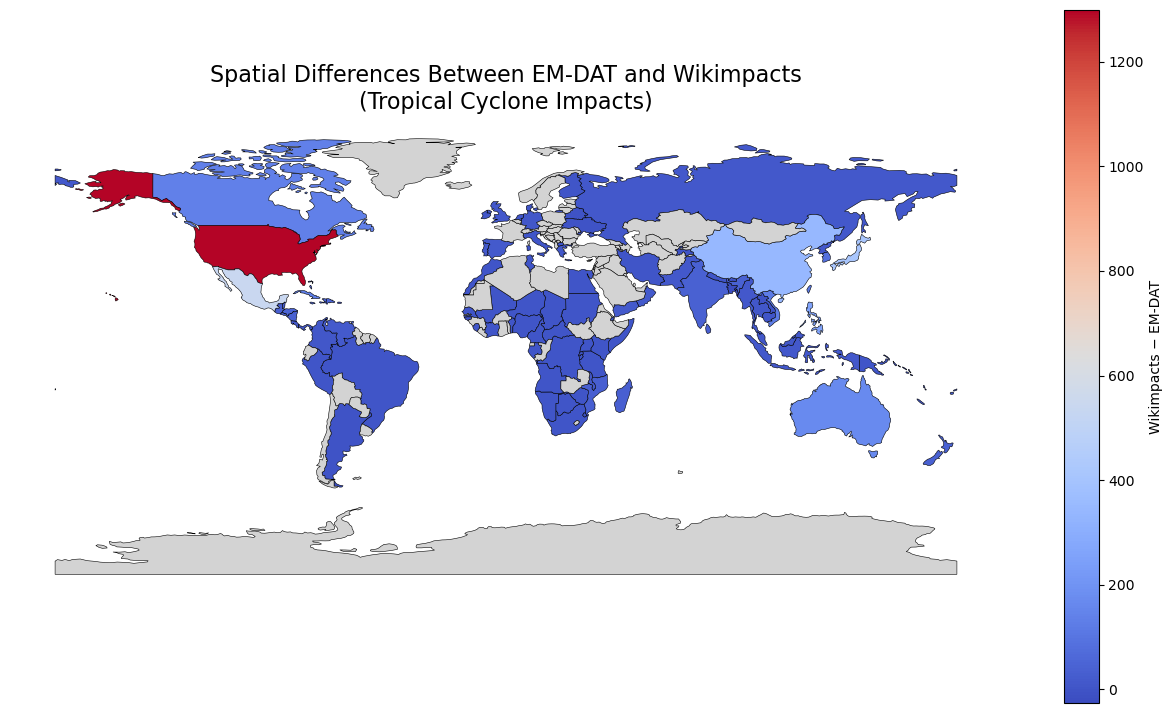

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

world_map.plot(
    column="difference",
    cmap="coolwarm",
    linewidth=0.4,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Wikimpacts − EM-DAT"},
    missing_kwds={"color": "lightgrey"},
    ax=ax
)

ax.set_title(
    "Spatial Differences Between EM-DAT and Wikimpacts\n(Tropical Cyclone Impacts)",
    fontsize=16
)
ax.axis("off")

# 8. Save the figure
plt.savefig(
    "EM_DAT_Wikimpacts_Spatial_Global_comparison.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

### Bonus: GUI
We opted to choose the Tkinter toolkit for our GUI because it is relatively simple and does not have a steep learning curve.

Before we could start coding our GUI we had to adjust our backend code slightly. Orignally, when you ran the backend code it would run all at once without stopping. As a consequence, if our GUI would import the code it would freeze until the code is finished running which is misleading for the user. <br>

The solution is to place the code in a function so that it only runs when called on. By doing this we can have loading indicators run before we run the code so that the user has feedback that the code is in progress. However, since our main code is now in a function we need to return our expected output (The file path to our graphs). <br>

An other adjustment we made was adding the line of code `if __name__ == "__main__": run_analysis()` so that the function can be run directly from the comandline. To see the code open the file "WORKINGFILE_PhiRu_FUNCTION.py". <br>

To summarize the affor mentioned and some other smaller changes:
* Move main logic into a function
* Return path of saved images
* Add comand line launch statement
* Add a year filter that can be set by the user in the GUI

#### Analysis in a single function:

TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0                         ['MEX']
1                         ['PHL']
2                         ['TWN']
3    ['Z03', 'CHN', 'Z08', 'Z02']
4                         ['JPN']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Administrative_Area_GID
Rows before cleaning: 4170
Rows after cleaning: 4005
TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0    ['CUB']
1    ['PHL']
2    ['PHL']
3    ['PHL']
4    ['SLB']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Administrative_Area_GID
Rows before cleaning: 6581
Rows after cleaning: 6324
TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0        ['MEX']
1        ['USA']
2        ['USA']
3        ['TWN']
4    ['CHN.HKG']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Adminis

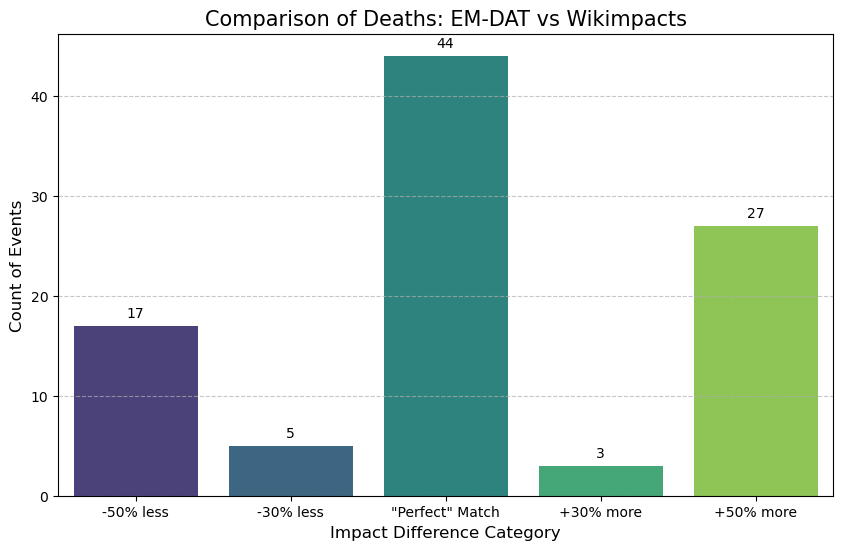

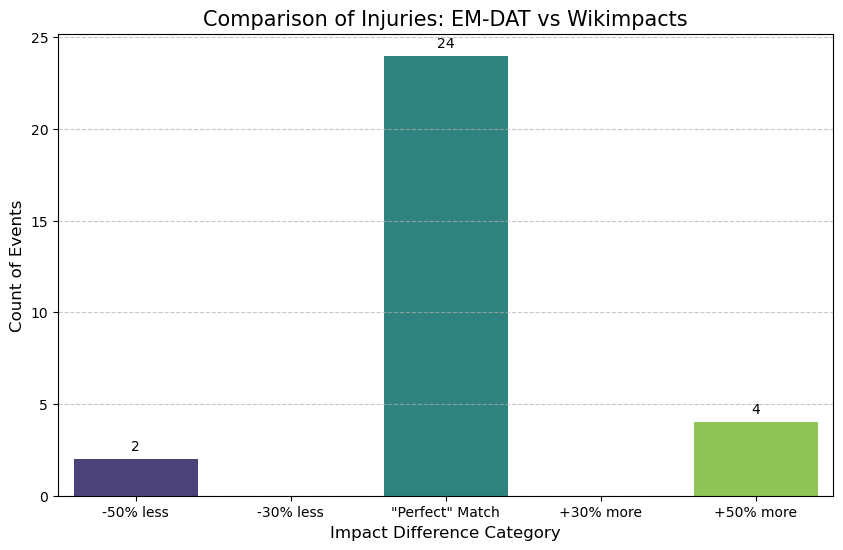

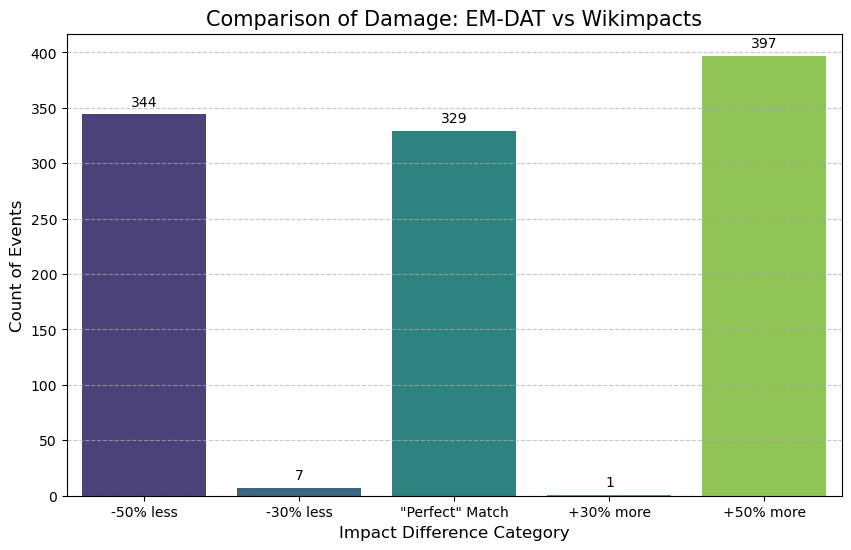

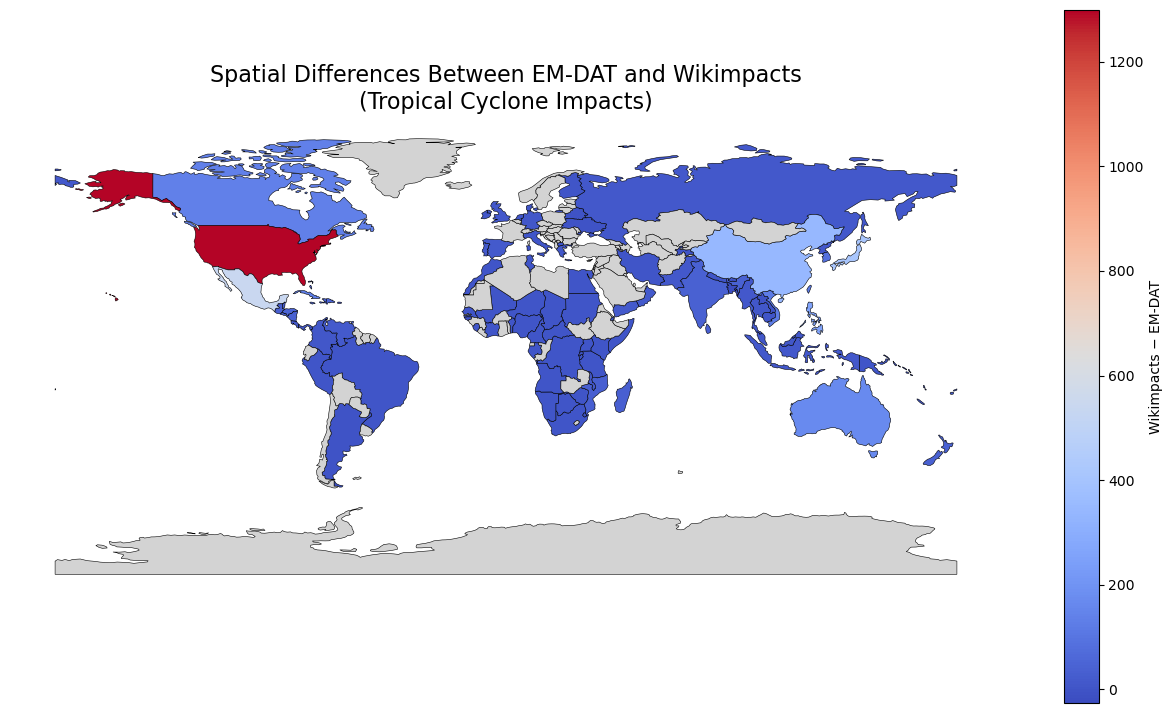

In [55]:
#THIS CODE WAS ADAPTED TO RUN IN JUPTYER NOTEBOOK -> THE RELATIVE PATH METHOD WAS CHANGED#

def run_analysis(filter_year):
    #1------- Connecting to Data base using dynamic paths

    notebook_dir = os.getcwd()                         # MODIFIED FOR NOTEBOOK
    project_root = os.path.dirname(notebook_dir)       # MODIFIED FOR NOTEBOOK
    db_path = os.path.join(project_root, 'Data', 'impactdb.v1.0.2.dg_filled.db')  # <-- database
    conn = sqlite3.connect(db_path)
    
    #2-------  Reading data from tables and selecting those with total in title
    # List all tables
    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn)
    
    all_total_tables = tables[tables["name"].str.startswith("Total")]["name"]
    
    #2(L1)-------
    # Concatenate to one big L1 dataframe
    L1_list = []
    for table_name in all_total_tables:
        df = pd.read_sql(f"SELECT * FROM {table_name};", conn)
        df["source_table"] = table_name
        L1_list.append(df)
    
    L1 = pd.concat(L1_list, ignore_index=True)
    
    #2(L3)--------
    
    spec_tables = tables[tables["name"].str.startswith("Specific")]["name"].tolist()
    L3 = {}  # dictionary of category -> dataframe
    
    for table_name in spec_tables: #for each table that starts with specific
        #classifyinging tables into three impacts deaths, injuries & damage
        if "Deaths" in table_name:
            category = "Deaths"
        elif "Injuries" in table_name:
            category = "Injuries"
        elif "Damage" in table_name:
            category = "Damage"
        else:
            continue
    
        df = pd.read_sql(f"SELECT * FROM {table_name};", conn)
        df["source_table"] = table_name
        L3.setdefault(category, []).append(df)
    
    # Get only Deaths, Injuries and Damage
    for category in L3:
        L3[category] = pd.concat(L3[category], ignore_index=True)
    
    L3_Deaths = L3.get("Deaths")
    L3_Injuries = L3.get("Injuries")
    L3_Damage = L3.get("Damage")
    
    
    #3----- Filtering for Tropical Storm/Cyclone events
    
    filter_criteria = L1["Main_Event"] == "Tropical Storm/Cyclone"
    L1_TC = L1[filter_criteria].copy() #Copy is very imprtant to ensure original data isn't altered
    
    tc_events = L1_TC["Event_ID"].unique()
    
    L3_Deaths_TC = dpf.filter_L3_tc(L3_Deaths, tc_events)
    L3_Injuries_TC = dpf.filter_L3_tc(L3_Injuries, tc_events)
    L3_Damage_TC  = dpf.filter_L3_tc(L3_Damage, tc_events)
    date_cols = [
        "Start_Date_Year", "Start_Date_Month", "Start_Date_Day",
        "End_Date_Year", "End_Date_Month", "End_Date_Day"]
    
    L1_TC_dates = L1_TC[["Event_ID"] + date_cols].drop_duplicates()
    
    L3_Deaths_TC = dpf.fill_dates(L3_Deaths_TC, L1_TC_dates, date_cols)
    L3_Injuries_TC = dpf.fill_dates(L3_Injuries_TC, L1_TC_dates, date_cols)
    L3_Damage_TC = dpf.fill_dates(L3_Damage_TC, L1_TC_dates, date_cols)
    
    #4---------- Filtering by year
            
    year_to_filter = filter_year
    L3_Deaths_TC_1900 = dpf.filter_year(L3_Deaths_TC, year_to_filter)
    L3_Injuries_TC_1900 = dpf.filter_year(L3_Injuries_TC, year_to_filter)
    L3_Damage_TC_1900 = dpf.filter_year(L3_Damage_TC, year_to_filter)
    
    #5---------- Aggregate by Administrative Area
    
    # Execute the process on each of our filtered dataframes:
    L3_Deaths_TC_1900_aggregated = dpf.aggregate_by_eventID(dpf.clean_dataframe(L3_Deaths_TC_1900))
    L3_Damage_TC_1900_aggregated = dpf.aggregate_by_eventID(dpf.clean_dataframe(L3_Damage_TC_1900))
    L3_Injuries_Damage_TC_1900_aggregated = dpf.aggregate_by_eventID(dpf.clean_dataframe(L3_Injuries_TC_1900))
    
    #6-------
    
    instance_tables = tables[tables["name"].str.startswith("Instance")]["name"].tolist()
    
    L2 = {}  # dictionary of category -> dataframe
    
    for table_name in instance_tables: #for each table that starts with instance
        #classifyinging tables into three impacts deaths, injuries & damage
        if "Deaths" in table_name:
            category = "Deaths"
        elif "Injuries" in table_name:
            category = "Injuries"
        elif "Damage" in table_name:
            category = "Damage"
        else:
            continue
    
        df = pd.read_sql(f"SELECT * FROM {table_name};", conn)
        df["source_table"] = table_name
        L2.setdefault(category, []).append(df)
    
    # Get only Deaths, Injuries and Damage
    for category in L2:
        L2[category] = pd.concat(L2[category], ignore_index=True)
    
    L2_Deaths = dpf.clean_dataframe(L2.get("Deaths"))
    L2_Injuries = dpf.clean_dataframe(L2.get("Injuries"))
    L2_Damage = dpf.clean_dataframe(L2.get("Damage"))
    
    #---- Using  Event_ID from ‘L3_*_1900_aggregated’ filter the events from ’ L2_*`, name as ‘L2_*_filter`
    #Extract Event ID from L3
    L3_deaths_ids = L3_Deaths_TC_1900_aggregated["Event_ID"].unique()
    L3_injuries_ids = L3_Injuries_Damage_TC_1900_aggregated["Event_ID"].unique()
    L3_damage_ids = L3_Damage_TC_1900_aggregated["Event_ID"].unique()
    
    #Filter L2 using these Event_ID's from L3
    L2_Deaths_filter = L2_Deaths[L2_Deaths["Event_ID"].isin(L3_deaths_ids)].copy()
    L2_Injuries_filter = L2_Injuries[L2_Injuries["Event_ID"].isin(L3_injuries_ids)].copy()
    L2_Damage_filter = L2_Damage[L2_Damage["Event_ID"].isin(L3_damage_ids)].copy()
    
    #----Using Administrative Area of L3_aggregated and L2_filter, get the same GIS and compute the difference between each impact category 
    # Equation is (‘L3_*_1900_aggregated’/ ‘L2_*_filter`)/ ‘L2_*_filter`.
    
    
    # --- Rename L2 GID column to match L3, AreaS to Area (more prone to error if not changed)
    L2_Deaths_filter = L2_Deaths_filter.rename(columns={"Administrative_Areas_GID": "Administrative_Area_GID"})
    L2_Injuries_filter = L2_Injuries_filter.rename(columns={"Administrative_Areas_GID": "Administrative_Area_GID"})
    L2_Damage_filter = L2_Damage_filter.rename(columns={"Administrative_Areas_GID": "Administrative_Area_GID"})
    
    # --- Merge L3 and L2 ---
    merged_deaths = L3_Deaths_TC_1900_aggregated.merge(
        L2_Deaths_filter,
        on=["Event_ID", "Administrative_Area_GID"],
        suffixes=("_L3", "_L2")
    )
    
    merged_injuries = L3_Injuries_Damage_TC_1900_aggregated.merge(
        L2_Injuries_filter,
        on=["Event_ID", "Administrative_Area_GID"],
        suffixes=("_L3", "_L2")
    )
    
    merged_damage = L3_Damage_TC_1900_aggregated.merge(
        L2_Damage_filter,
        on=["Event_ID", "Administrative_Area_GID"],
        suffixes=("_L3", "_L2")
    )
    
    # --- Keep only the required columns (including both GIDs) ---
    cols_to_keep = [
        "Event_ID",
        "Administrative_Area_GID",
        "Num_Min_L3", "Num_Max_L3", "Num_Approx_L3",
        "Num_Min_L2", "Num_Max_L2", "Num_Approx_L2"
    ]
    
    merged_deaths = merged_deaths[cols_to_keep].copy()
    merged_injuries = merged_injuries[cols_to_keep].copy()
    merged_damage = merged_damage[cols_to_keep].copy()
    
    # Compute relative differences
    impact_columns = ["Num_Min", "Num_Max", "Num_Approx"]
    
    for col in impact_columns:
        merged_deaths[f"{col}_rel_diff"] = dpf.rel_diff_between_data_levels(merged_deaths, col)
        merged_injuries[f"{col}_rel_diff"] = dpf.rel_diff_between_data_levels(merged_injuries, col)
        merged_damage[f"{col}_rel_diff"] = dpf.rel_diff_between_data_levels(merged_damage, col)
    
    # Compute average relative difference per category
    avg_rel_diff_deaths = merged_deaths[[c for c in merged_deaths.columns if "rel_diff" in c]].mean()
    avg_rel_diff_injuries = merged_injuries[[c for c in merged_injuries.columns if "rel_diff" in c]].mean()
    avg_rel_diff_damage = merged_damage[[c for c in merged_damage.columns if "rel_diff" in c]].mean()
    
    # --- Task 7
    
    # Load EM-DAT Excel file
    emdat = pd.read_excel(os.path.join(project_root, 'Data', 'EMDAT.xlsx'),sheet_name="EM-DAT Data")
    
    emdat = emdat[[
        "ISO",
        "Start Year", "Start Month",
        "End Year", "End Month", 'Total Deaths', 'No. Injured', "Total Damage ('000 US$)", "Total Damage, Adjusted ('000 US$)"
    ]].copy()
    
    cols_for_matching = [
        "Event_ID",
        "Administrative_Area_GID",
        "Start_Date_Year", "Start_Date_Month",
        "End_Date_Year", "End_Date_Month",
        "Num_Min", "Num_Max", "Num_Approx"
    ]
    
    L2_Deaths_match = L2_Deaths_filter[cols_for_matching].copy()
    L2_Injuries_match = L2_Injuries_filter[cols_for_matching].copy()
    L2_Damage_match = L2_Damage_filter[cols_for_matching].copy()
    
    match_deaths = L2_Deaths_match.merge(
        emdat,
        left_on=["Administrative_Area_GID", "Start_Date_Year", "Start_Date_Month", "End_Date_Year", "End_Date_Month"],
        right_on=["ISO", "Start Year", "Start Month", "End Year", "End Month"],
        how="inner")
    
    match_injuries = L2_Injuries_match.merge(
        emdat,
        left_on=["Administrative_Area_GID", "Start_Date_Year", "Start_Date_Month", "End_Date_Year", "End_Date_Month"],
        right_on=["ISO", "Start Year", "Start Month", "End Year", "End Month"],
        how="inner")
    
    match_damage = L2_Damage_match.merge(
        emdat,
        left_on=["Administrative_Area_GID", "Start_Date_Year", "Start_Date_Month", "End_Date_Year", "End_Date_Month"],
        right_on=["ISO", "Start Year", "Start Month", "End Year", "End Month"],
        how="inner")
    
    cols_final = [
        "Event_ID",
        "ISO",
        "Administrative_Area_GID",
        "Start_Date_Year", "Start_Date_Month",
        "End_Date_Year", "End_Date_Month",
        "Start Year", "Start Month", "End Year", "End Month",
        "Num_Min", "Num_Max", "Num_Approx",
        "Total Deaths",
        "No. Injured",
        "Total Damage ('000 US$)",
        "Total Damage, Adjusted ('000 US$)"]
    
    match_deaths = match_deaths[cols_final].copy()
    match_injuries = match_injuries[cols_final].copy()
    match_damage = match_damage[cols_final].copy()
    
    EM_DAT_Wikimapcts_Matched = pd.concat(
        [match_deaths, match_injuries, match_damage],
        ignore_index=True)
    
    
    # --- Execute for each Category ---
    
    print("Processing Deaths...")
    match_deaths_processed = dpf.process_and_plot_impacts(
        match_deaths, 
        category_name="Deaths", 
        emdat_col="Total Deaths"
    )
    
    print("Processing Injuries...")
    match_injuries_processed = dpf.process_and_plot_impacts(
        match_injuries, 
        category_name="Injuries", 
        emdat_col="No. Injured"
    )
    
    print("Processing Damage...")
    match_damage_processed = dpf.process_and_plot_impacts(
        match_damage, 
        category_name="Damage", 
        emdat_col="Total Damage, Adjusted ('000 US$)"
    )
    
        # Task 8 spatial map
    print("Processing Spatial Map...")
    spatial_path = dpf.process_and_plot_spatial_differences(
        emdat,
        L2_Deaths_filter,
        L2_Injuries_filter,
        L2_Damage_filter
    )

    image_dir = os.path.join(project_root, 'Images')
    return {
        "Deaths": os.path.join(image_dir, "EM_DAT_Wikimpacts_Deaths_comparison.png"),
        "Injuries": os.path.join(image_dir, "EM_DAT_Wikimpacts_Injuries_comparison.png"),
        "Damage": os.path.join(image_dir, "EM_DAT_Wikimpacts_Damage_comparison.png"), 
        "Spatial": os.path.join(image_dir, "EM_DAT_Wikimpacts_Spatial_Global_comparison.png")}
    
if __name__ == "__main__":
    run_analysis(1900)

#### GUI:

TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0                         ['MEX']
1                         ['PHL']
2                         ['TWN']
3    ['Z03', 'CHN', 'Z08', 'Z02']
4                         ['JPN']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Administrative_Area_GID
Rows before cleaning: 4170
Rows after cleaning: 4005
TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0    ['CUB']
1    ['PHL']
2    ['PHL']
3    ['PHL']
4    ['SLB']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Administrative_Area_GID
Rows before cleaning: 6581
Rows after cleaning: 6324
TARGET COLUMN: Administrative_Area_GID
FIRST VALUES:
 0        ['MEX']
1        ['USA']
2        ['USA']
3        ['TWN']
4    ['CHN.HKG']
Name: Administrative_Area_GID, dtype: object
COLUMN DTYPE: object
PYTHON TYPE OF VALUE: <class 'str'>
Detected column: Adminis

SystemExit: 

C:\Users\lukas\anaconda3\envs\PhiRuProject\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


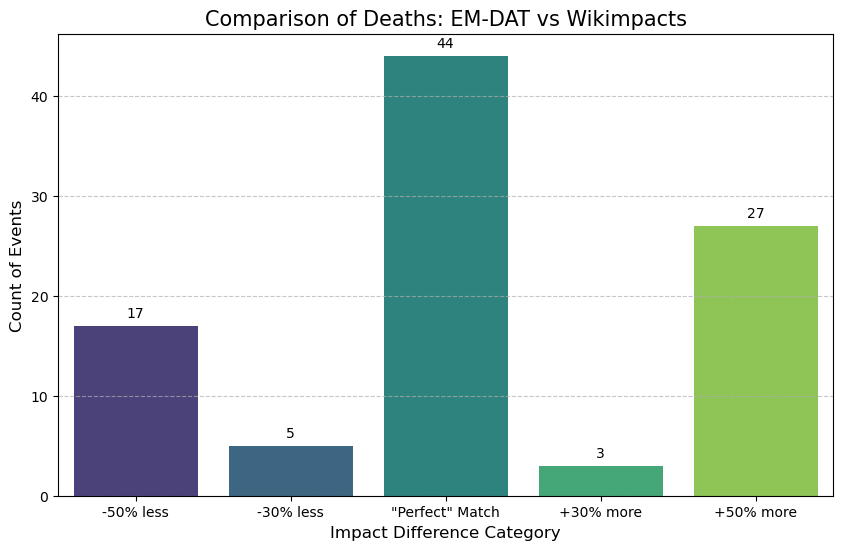

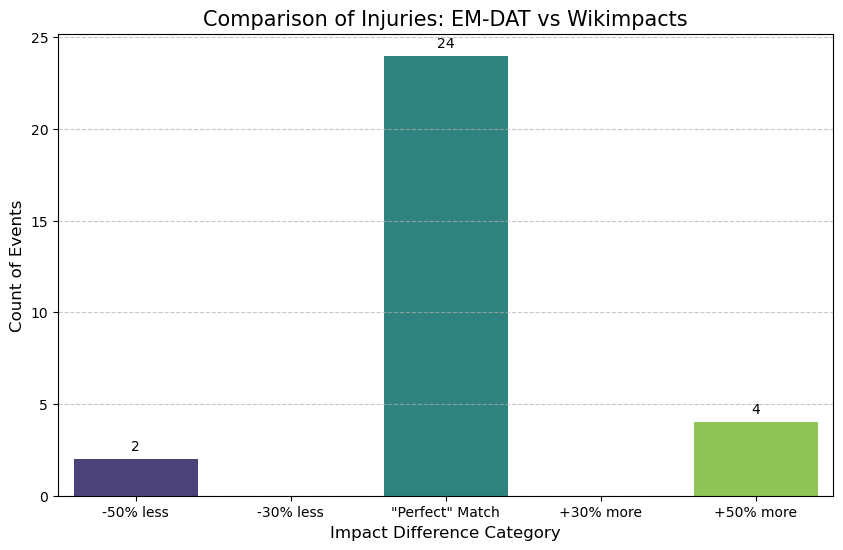

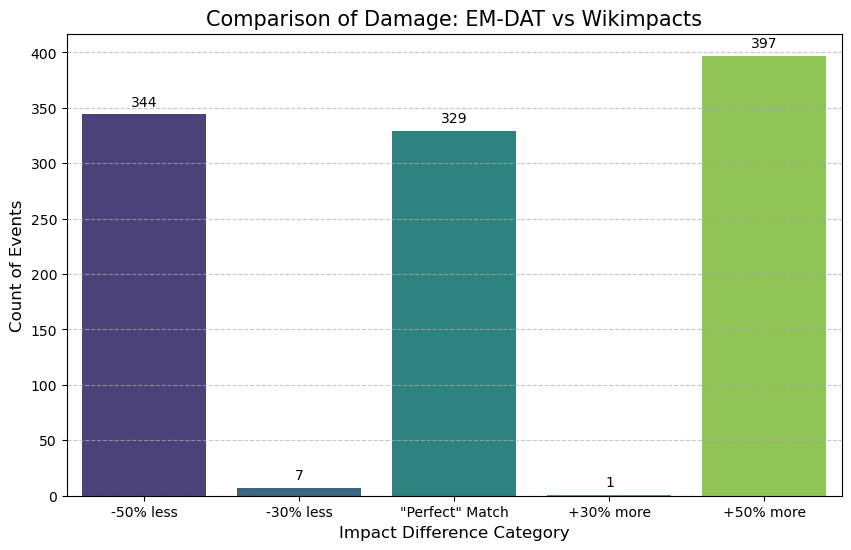

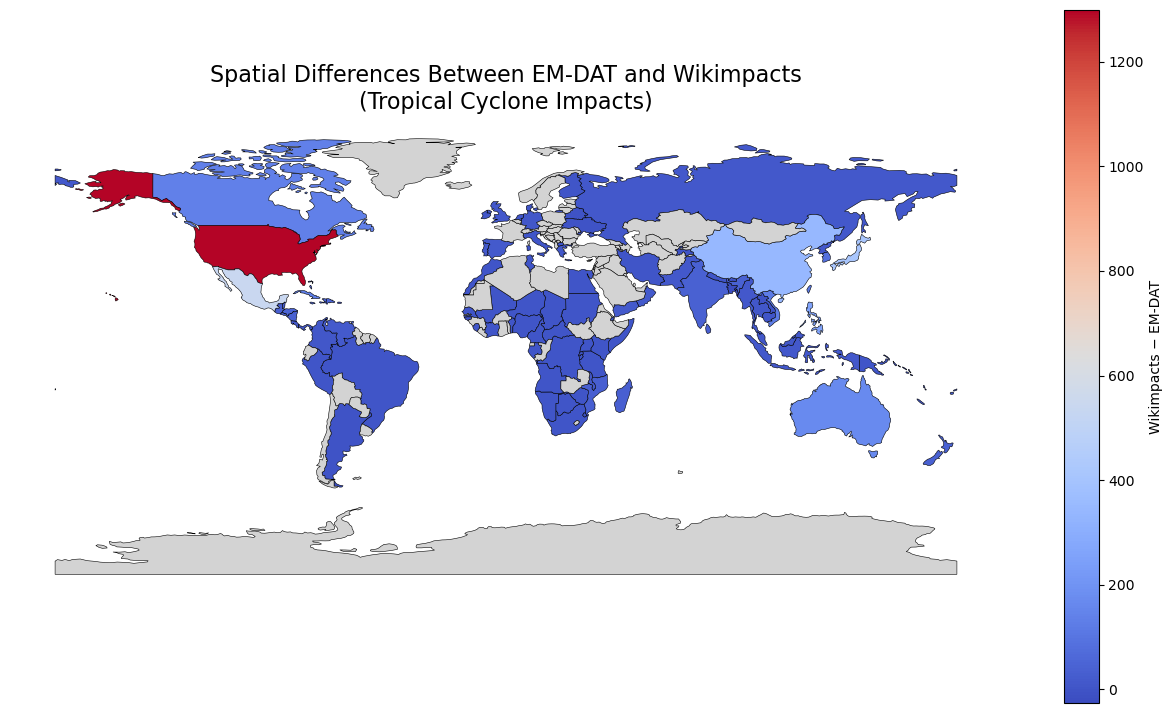

In [53]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 18 18:32:26 2025

@author: lukas
"""
import tkinter as tk
from tkinter import ttk, messagebox
from PIL import Image, ImageTk
import threading
import os
import sys


# Import your backend script
import WORKINGFILE_PhiRu_FUNCTION as backend

class AnalysisApp:
    def __init__(self, root):
        self.root = root
        self.root.title("EM-DAT vs Wikimpacts Analyzer")
        self.root.geometry("1000x800")
        
        # Store image paths here after analysis runs
        self.image_paths = {}

        # --- GUI LAYOUT ---
        
        # 1. Top Control Panel
        control_frame = ttk.Frame(root, padding=10)
        control_frame.pack(side="top", fill="x")

        # LableFrame to group settings visually
        settings_frame = ttk.LabelFrame(control_frame, text="Filter Settings", padding=10)
        settings_frame.pack(side="left", padx=10)

        # Start Year Input
        ttk.Label(settings_frame, text="Filter data after year:").pack(side="left")
        self.start_year_var = tk.StringVar(value="1900") # Default value
        self.entry_start = ttk.Entry(settings_frame, textvariable=self.start_year_var, width=8)
        self.entry_start.pack(side="left", padx=5) # Add some space to the right

        # The Run Button
        self.run_btn = ttk.Button(control_frame, text="Run Analysis", command=self.start_analysis_thread)
        self.run_btn.pack(side="left", padx=5)

        # Status Label (to show "Running..." or "Done")
        self.status_var = tk.StringVar(value="Ready")
        self.status_lbl = ttk.Label(control_frame, textvariable=self.status_var, font=("Arial", 10, "italic"))
        self.status_lbl.pack(side="left", padx=10)

        # 2. Graph Selection Buttons (Disabled initially)
        self.btn_frame = ttk.Frame(root, padding=10)
        self.btn_frame.pack(side="top", fill="x")
        
        self.view_deaths_btn = ttk.Button(self.btn_frame, text="View Deaths", state="disabled", command=lambda: self.show_image("Deaths"))
        self.view_deaths_btn.pack(side="left", padx=5)
        
        self.view_injuries_btn = ttk.Button(self.btn_frame, text="View Injuries", state="disabled", command=lambda: self.show_image("Injuries"))
        self.view_injuries_btn.pack(side="left", padx=5)
        
        self.view_damage_btn = ttk.Button(self.btn_frame, text="View Damage", state="disabled", command=lambda: self.show_image("Damage"))
        self.view_damage_btn.pack(side="left", padx=5)

        self.view_spatial_btn = ttk.Button(self.btn_frame, text="View Spatial Map", state="disabled",command=lambda: self.show_image("Spatial"))
        self.view_spatial_btn.pack(side="left", padx=5)

        # 3. Image Display Area
        self.image_canvas = tk.Label(root, text="Run analysis to generate graphs", bg="#f0f0f0")
        self.image_canvas.pack(side="top", fill="both", expand=True, padx=20, pady=20)
        
        # Rewire the "X" button as a safe exit
        self.root.protocol("WM_DELETE_WINDOW", self.safe_exit)

    def start_analysis_thread(self):
        """Starts the backend process in a separate thread so GUI doesn't freeze."""
        self.run_btn.config(state="disabled")
        self.status_var.set("Running analysis... Please wait.")
        
        # Check if the user typed a year
        try:
            s_year = int(self.start_year_var.get())
                
        except ValueError:
            messagebox.showerror("Input Error", "Please enter valid numbers for year.")
            return
        
        # Run the actual work in a background thread
        self.run_btn.config(state="disabled")
        self.status_var.set(f"Running analysis from {s_year} onwards ...")
        
        # Pass the years to the thread
        thread = threading.Thread(target=self.run_backend_logic, args=(s_year,))
        thread.start()

    def run_backend_logic(self,s_year):
        """This function runs in the background."""
        try:
            self.image_paths = backend.run_analysis(s_year)
            self.root.after(0, self.analysis_complete)
        except Exception as e:
            error_msg = str(e)
            self.root.after(0, lambda: messagebox.showerror("Error", error_msg))
            self.root.after(0, lambda: self.status_var.set("Error occurred."))
            self.root.after(0, lambda: self.run_btn.config(state="normal"))

    def analysis_complete(self):
        """Called when analysis finishes successfully."""
        self.status_var.set("Analysis Complete! Select a graph below.")
        self.run_btn.config(state="normal")
        
        # Enable the view buttons
        self.view_deaths_btn.config(state="normal")
        self.view_injuries_btn.config(state="normal")
        self.view_damage_btn.config(state="normal")
        self.view_spatial_btn.config(state="normal")
        
        
        
        # Show the first image automatically
        self.show_image("Deaths")

    def show_image(self, category):
        """Loads and displays the image for the selected category."""
        path = self.image_paths.get(category)
        if path and os.path.exists(path):
            # Load Image using Pillow
            load = Image.open(path)
            
            # Resize image to fit window if necessary (Optional)
            load = load.resize((800, 600), Image.Resampling.LANCZOS)
            
            render = ImageTk.PhotoImage(load)
            
            # Update the label
            self.image_canvas.config(image=render, text="")
            self.image_canvas.image = render # Keep a reference! (Crucial for Tkinter)
            self.status_var.set(f"Viewing: {category}")
        else:
            messagebox.showwarning("File Missing", f"Could not find image at {path}")
        
    def safe_exit(self):
        """Ensures the application and kernel shut down completely."""
        if messagebox.askokcancel("Quit", "Do you want to quit the program?"):
            # This kills the main window and stops the mainloop
            self.root.destroy()
            
            # Kills the python kernal
            sys.exit()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    root = tk.Tk()
    app = AnalysisApp(root)
    root.mainloop()